In [2]:
import numpy as np
import torch

In [19]:
import os

def clear_console():
    os.system('cls' if os.name == 'nt' else 'clear')

In [3]:
def model(state, unpacked_params):
    l1, b1, l2, b2, l3, b3 = unpacked_params
    y = torch.nn.functional.linear(state, l1, b1)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, l2, b2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, l3, b3)
    y = torch.log_softmax(y, dim=0)
    return y

为了让重组和变异更简单，我们创建一个一维张量作为一个 population，这个 population 使用的时候会被转化为独立的矩阵作为神经网络每一层的参数。

In [15]:
def unpack_params(params, layers=[(25, 4), (10, 25), (2, 10)]):
    unpacked_params = []
    end = 0
    for i, l in enumerate(layers):
        # [n, n, n, n, n, n, n, n, n, n, n, ......]
        #  ^                    ^
        # start                end
        # capture the elements of the layer in the flat params array
        start, end = end, end + np.prod(l) # 25 x 4
        # calling `view` reshapes the flat array into shape `l`
        weights = params[start:end].view(l)
        start, end = end, end + l[0]
        bias = params[start:end]
        unpacked_params.extend([weights, bias])
    return unpacked_params

这种将所有参数变为一个一维数组可以方便重组和变异。而另一种方式是，可以将一层的参数视为“染色体”，在重组和变异的时候，只在同样“形状”的染色体之间进行。这种做法比较复杂，但好处在于不同层之间的参数不会相互泄露和混合。

In [5]:
# N: number of individuals in the population
# size: the length of the parameter vectors
# 
# in this case
#   size = (25 x 4 + 25) + (10 x 25 + 10) + (2 x 10 + 2) = 407
#             layer1            layer2          layer3
def spawn_population(N=50, size=407):
    pop = []
    for i in range (N):
        vec = torch.randn(size) / 2.0
        fit = 0
        p = { 'params': vec, 'fitness': fit }
        pop.append(p)
    return pop

In [17]:
def recombine(agent1, agent2):
    x1 = agent1['params']
    x2 = agent2['params']
    l = x1.shape[0]
    split_pt = np.random.randint(l)
    child1 = torch.zeros(l)
    child2 = torch.zeros(l)
    child1[0:split_pt] = x1[0:split_pt]
    child1[split_pt:] = x2[split_pt:]
    child2[0:split_pt] = x2[0:split_pt]
    child2[split_pt:] = x1[split_pt:]
    c1 = { 'params': child1, 'fitness': 0.0 }
    c2 = { 'params': child2, 'fitness': 0.0 }
    return c1, c2

In [7]:
def mutate(agent, rate=0.01):
    x = agent['params']
    # number of elements to change
    num_to_change = int(rate * x.shape[0])
    # select the indexes of the elements which are about to change
    idx = np.random.randint(low=0, high=x.shape[0], size=(num_to_change,))
    x[idx] = torch.randn(num_to_change) / 10.0
    agent['params'] = x
    return agent

In [13]:
import gymnasium

env = gymnasium.make('CartPole-v1')

def test_model(agent):
    done = False
    state = torch.from_numpy(env.reset()[0]).float()
    score = 0
    while not done:
        params = unpack_params(agent['params'])
        probs = model(state, params)
        action = torch.distributions.Categorical(probs=probs).sample()
        state_, reward, done, truncated, info = env.step(action.item())
        state = torch.from_numpy(state_).float()
        score += 1
    return score

In [9]:
def evaluate_population(pop):
    tot_fit = 0
    lp = len(pop) 
    for agent in pop:
        score = test_model(agent)
        agent['fitness'] = score
        tot_fit += score
    avg_fit = tot_fit / lp
    return pop, avg_fit

在生成下一代的时候，需要对 parents 进行选择，**probalistic selection mechanism** 是基于 `fitness` 值进行的，以这一代的所有 `agent.fitness` 生成概率分布，然后基于这个概率分布选择 parents。对于遗传算法来说，这种方法一般会导致收敛非常快，效果不一定很好。遗传算法需要更多的 exploration，所以这里我们采用一种叫 **tournament-style selection** 的算法。

在这种算法中，先随机从这一代选取 `tournament_size` 个数的个体，然后从中选择 `fitness` 值最高的两个作为 parents。当 `tournament_size` 为 population 个数的时候，就是最优选择，当其为 2 的时候，就是随机选择。通常可以设定一个基于 population 大小的比例，比如 20%。当然这个值也是一个超参数，是需要实验的。

In [10]:
def next_generation(pop, mut_rate=0.001, tournament_size=0.2):
    new_pop = []
    lp = len(pop)
    while len(new_pop) < len(pop):
        random_indexes = np.random.randint(low=0, high=lp, size=(int(tournament_size * lp)))
        # selects a subset of the population as the tournament batch
        batch = np.array([
            [i, agent['fitness']] for (i, agent) in enumerate(pop) if i in random_indexes
        ])
        # from low to high
        scores = batch[batch[:, 1].argsort()]
        i0, i1 = int(scores[-1][0]), int(scores[-2][0])
        parent0, parent1 = pop[i0], pop[i1]
        offspring_ = recombine(parent0, parent1)
        child1 = mutate(offspring_[0], rate=mut_rate)
        child2 = mutate(offspring_[1], rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

In [20]:
def train():
    num_generations = 25
    population_size = 500
    mutation_rate = 0.01
    pop_fit = []
    pop = spawn_population(N=population_size, size=407)
    for i in range(num_generations):
        pop, avg_fit = evaluate_population(pop)
        pop_fit.append(avg_fit)
        pop = next_generation(pop, mut_rate=mutation_rate, tournament_size=0.2)

        clear_console()
        print('%d / %d' % (i + 1, num_generations))
    
    return pop_fit

In [21]:
history = train()

1 / 25
2 / 25
3 / 25
4 / 25
5 / 25
6 / 25
7 / 25
8 / 25
9 / 25
10 / 25
11 / 25
12 / 25
13 / 25
14 / 25
15 / 25
16 / 25
17 / 25
18 / 25
19 / 25
20 / 25
21 / 25
22 / 25
23 / 25
24 / 25
25 / 25


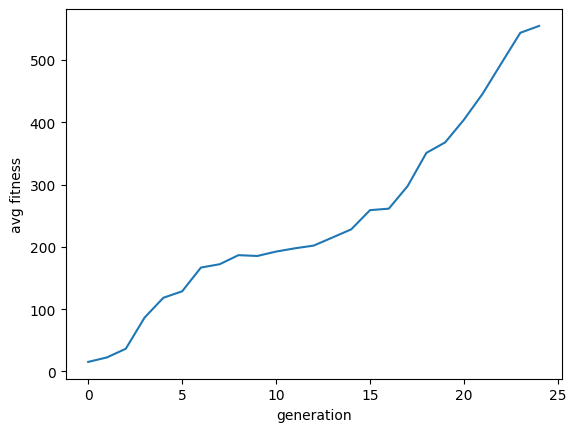

In [23]:
import matplotlib.pyplot as plt

plt.xlabel('generation')
plt.ylabel('avg fitness')
plt.plot(history)